#**1 Introducción**
En el siguiente cuaderno se realizara la aplicacion del filtro Box Blur[1] a una imagen parametrizada. Para realizar el filtro se calcula la suma de todos los valores vecinos de ese pixel incluyendo el mismo pixel, una vez calculada la suma se realiza el promedio y se guarda el resultado en el mismo pixel. Ejemplo:
imagen = [1, 1, 1] 
         [1, 7, 1]
         [1, 1, 1]

La imagen resultante será (1+1+1+1+7+1+1+1+1) = 15 / 9 = 1.6666 = 1

Este se debe repetir para cada color Rojo, Verde y Azul.

La desventaja de este algoritmo es que no toma los bordes de la imagen, por tal motivo los bordes no se van a difuminar.


#**2 Armado del ambiente**
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [28]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/jonyfernandez/TP2-SOA-Android/blob/master/HPC/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/jonyfernandez/TP2-SOA-Android/blob/master/HPC/unlam.jpg?raw=true -O imagen.jpg

# Verificamos que haya escrito una URL valida
if not (type(url_imagen) is str) or (url_imagen == ""):
  raise TypeError("Se tiene que ingresar una URL valida")

# Guardamos la imagen
!wget {url_imagen} -O imagen.jpg

--2021-07-04 23:01:26--  https://github.com/jonyfernandez/TP2-SOA-Android/blob/master/HPC/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jonyfernandez/TP2-SOA-Android/raw/master/HPC/unlam.jpg [following]
--2021-07-04 23:01:26--  https://github.com/jonyfernandez/TP2-SOA-Android/raw/master/HPC/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jonyfernandez/TP2-SOA-Android/master/HPC/unlam.jpg [following]
--2021-07-04 23:01:26--  https://raw.githubusercontent.com/jonyfernandez/TP2-SOA-Android/master/HPC/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443..

##2.2 Instala en el cuaderno el módulo de CUDA de Python

In [29]:
!pip install pycuda

#**3 Desarrollo CPU**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tiempo de conversión de imagen: 17049.123 [ms]
Tiempo Total: 17126.985 [ms]
Detalles: RGB- [1024, 768]


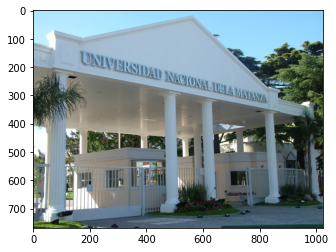

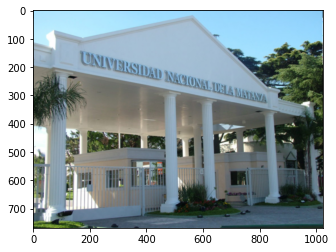

In [ ]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
imagen = Image.open( img_nombre )
# Optengo las proporsiones de la imagen.
img_ancho, img_alto = imagen.size
# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(imagen)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

#Muestro la imagen original antes de aplicar el filtro.
plt.figure()
imgplot=plt.imshow( img_pic_cpu )

#Tiempo para el aplicado del filtro.
tiempo_img = datetime.now()

#Aplico Box Blur

#For para los colores Rojo, Verde y Azul
for channel in (0,1,2):
  #For para el ancho sin tomar el borde
  for y in range(1, img_ancho - 1):
    #For para el alto sin tomar el borde
    for x in range(1, img_alto - 1):
      suma = 0
      suma += img_pic_cpu[x, y, channel]
      suma += img_pic_cpu[x - 1, y - 1, channel]
      suma += img_pic_cpu[x - 1, y, channel]
      suma += img_pic_cpu[x - 1, y + 1, channel]
      suma += img_pic_cpu[x, y - 1, channel]
      suma += img_pic_cpu[x, y + 1, channel]
      suma += img_pic_cpu[x + 1, y - 1, channel]
      suma += img_pic_cpu[x + 1, y, channel]
      suma += img_pic_cpu[x + 1, y + 1, channel]
      img_picR_cpu[x,y,channel] = sum / 9
      

# end time
tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# Muestro los atributos de las imagenes
print("Detalles: " + imagen.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )


#**4 Desarrollo GPU**

In [30]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
imagen = Image.open( img_nombre )
# Optengo las proporsiones de la imagen.
img_ancho, img_alto = imagen.size

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(imagen)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_BoxBlur( int ancho, int alto, int *img_O, int *img_R, int channel ) {

  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  int suma = 0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx >= 1 && idx < ancho - 1 && idy >= 1 && idy < alto - 1 ) {

         sum += img_O[ ((idx + (idy * ancho)) * 3) + channel ];
         sum += img_O[ (((idx - 1) + ((idy - 1) * ancho)) * 3) + channel ];
         sum += img_O[ (((idx - 1) + (idy * ancho)) * 3) + channel];
         sum += img_O[ (((idx - 1) + ((idy + 1) * ancho)) * 3) + channel];
         sum += img_O[ ((idx + ((idy - 1) * ancho)) * 3) + channel];
         sum += img_O[ ((idx + ((idy + 1) * ancho)) * 3) + channel];
         sum += img_O[ (((idx + 1) + ((idy - 1) * ancho)) * 3) + channel];
         sum += img_O[ (((idx + 1) + (idy * ancho)) * 3) + channel];
         sum += img_O[ (((idx + 1) + ((idy + 1) * ancho)) * 3) + channel];

         suma /= 9;

         img_R[ ((idx + ( idy * ancho )) * 3 ) + channel] = suma;

         suma = 0;
  }
}
""")

# Muestro los atributos de la imagen y como se ve antes del filtro.
print("Imagen del filtro: " + img_nombre + " -" + imagen.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_BoxBlur")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x - 1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y - 1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( np.int32(img_ancho), np.int32(img_ancho), img_O_gpu, img_R_gpu, 0, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
kernel( np.int32(img_ancho), np.int32(img_ancho), img_O_gpu, img_R_gpu, 1, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
kernel( np.int32(img_ancho), np.int32(img_ancho), img_O_gpu, img_R_gpu, 2, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

RuntimeError: ignored

#**5 Metricas**

#**6 Conclusiones**

#**7 Bibliografía**
[1] Algoritmo Box Blur: [WEB](https://wachino.github.io/codefights/codefights-arcade/codefights-arcade-thecore/108_boxBlur/README.html)

[2] Wiki Sistemas Operativos Avanzados: [WIKI](http://www.so-unlam.net.ar/wiki/index.php/PUBLICO:HPC)